##### TF-IDF - Search
##### Document Clustering

In [123]:
import nltk, re, spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

import pandas as pd, numpy as np
import contractions
from collections import Counter
from num2words import num2words
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def convert_lower_case(data):
    return np.char.lower(data)

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

In [3]:
# Reading the csv into pandas dataframe
cols=['num','id','title','publication', 'author', 'date', 'year', 'month', 'url', 'content']

news_articles = pd.read_csv('articles1.csv', engine='python', names=cols, nrows=10000)
news_articles = news_articles[pd.to_numeric(news_articles['num'], errors='coerce').notnull()]

nRow, nCol = news_articles.shape
print(f'There are {nRow} row and {nCol} columns')

news_articles.head(2)

There are 9999 row and 10 columns


,num,id,title,publication,author,date,year,month,url,content
1,0.0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
2,1.0,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."


In [4]:
content_df = news_articles.content.to_frame()[:500]

content_df.sample(5, random_state=0)

,content
9447,"Congressman Jason Chaffetz, head of the House ..."
899,While many Super Bowl advertisers chose to be ...
2399,"MONTGOMERY, Ala. — Gov. Robert Bentley enga..."
5907,"In the beginning, there was the book. Famously..."
2344,Donald J. Trump’s low approval ratings and the...


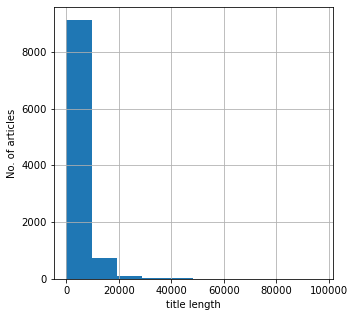

In [5]:
plt.figure(figsize=(5, 5))
plt.xlabel('title length')
plt.ylabel('No. of articles')

content_df['content'].str.len().hist()

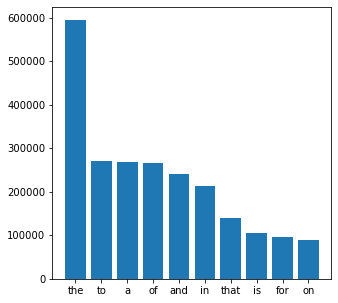

In [17]:
stop_words = set(stopwords.words('english'))

# Before removing let's check the occurrence of stopwords in title

def plot_top_stopwords_barchart(text):
    new = text.str.split().values.tolist()
    corpus = [word for i in new for word in i]
    from collections import defaultdict
    dic = defaultdict(int)
    for word in corpus:
        if word in stop_words: dic[word]+=1
    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
    x, y = zip(*top)
    plt.figure(figsize=(5, 5))
    plt.bar(x, y)
    
plot_top_stopwords_barchart(content_df['content'])

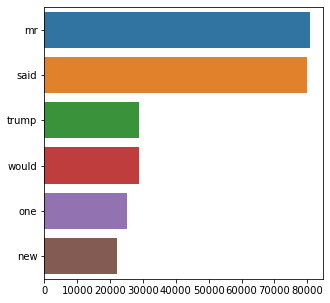

In [22]:
def plot_non_stopwords_barchart(text):
    new = text.str.split().values.tolist()
    corpus = [word for i in new for word in i]
    
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:50]:
        if word not in stop_words:
            x.append(word)
            y.append(count)
    plt.figure(figsize=(5, 5))
    sns.barplot(x=y, y=x)

plot_non_stopwords_barchart(content_df['content'])

In [6]:
content_df['tokenized_content'] = content_df.content.apply(lambda x: preprocess(x))
content_df.sample(5, random_state=5)

### TF-IDF  “Term Frequency — Inverse Data Frequency”.

Refer to *tfidf-ranking-cosine-similarity-matching-score.ipynb* for a detail implementation of tfidf.

In [65]:
content_df = content_df.reset_index(drop=True)

In [118]:
vector = TfidfVectorizer(max_df=0.3, # drop words that occur in more than X percent of documents
                        #min_df=8, # only use words that appear at least X times
                        stop_words='english', # remove stop words
                        lowercase=True, # Convert everything to lower case 
                        use_idf=True, # Use idf
                        norm=u'l2', # Normalization
                        smooth_idf=True # Prevents divide-by-zero errors
                        )

content_subset = content_df['tokenized_content'][:100]
tfidf = vector.fit_transform(content_subset)

In [119]:
tfidf_subset = tfidf.toarray()
vocab = vector.get_feature_names()

tfidf_df = pd.DataFrame(np.round(tfidf_subset, 2), columns=vocab)

In [89]:
tfidf_df  # tfidf often yield to highly sparse matrix

,115th,11th,125th,12th,13th,146th,150th,151st,15th,175th,...,écoutant,écrire,écrivain,église,élise,érabl,étai,était,état,être
0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.01,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
tfidf_subset

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [92]:
doc_smiliarity_matrix_with_euclidean_distance = euclidean_distances(tfidf_subset, tfidf_subset) #Diagonal
doc_smiliarity_matrix_with_euclidean_distance

array([[0.        , 1.39683795, 1.40340935, ..., 1.40256253, 1.39437787,
        1.39469157],
       [1.39683795, 0.        , 1.39146916, ..., 1.39158128, 1.3941255 ,
        1.3931259 ],
       [1.40340935, 1.39146916, 0.        , ..., 1.39570105, 1.40230206,
        1.40212726],
       ...,
       [1.40256253, 1.39158128, 1.39570105, ..., 0.        , 1.40433681,
        1.40731436],
       [1.39437787, 1.3941255 , 1.40230206, ..., 1.40433681, 0.        ,
        1.28330263],
       [1.39469157, 1.3931259 , 1.40212726, ..., 1.40731436, 1.28330263,
        0.        ]])

In [93]:
#Find the most relevant document for the 1st document according to Eulcidean distance. Note the use of np.argmin
result_idx = np.argmin(doc_smiliarity_matrix_with_euclidean_distance[0][1:]) + 1
query = content_df.loc[0, 'content']
result = content_df.loc[result_idx, 'content']
print(query)
print()
print(result)

WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been d

### Cosine Similarity

In [94]:
doc_smiliarity_matrix_with_cosine = cosine_similarity(tfidf_subset, tfidf_subset) 
doc_smiliarity_matrix_with_cosine

array([[1.        , 0.02442187, 0.0152211 , ..., 0.01640917, 0.02785518,
        0.02741771],
       [0.02442187, 1.        , 0.03190678, ..., 0.03175076, 0.02820705,
        0.02960012],
       [0.0152211 , 0.03190678, 1.        , ..., 0.02600929, 0.01677447,
        0.01701957],
       ...,
       [0.01640917, 0.03175076, 0.02600929, ..., 1.        , 0.01391907,
        0.00973314],
       [0.02785518, 0.02820705, 0.01677447, ..., 0.01391907, 1.        ,
        0.17656718],
       [0.02741771, 0.02960012, 0.01701957, ..., 0.00973314, 0.17656718,
        1.        ]])

In [95]:
#Find the most relevant document for the 1st document according to Eulcidean distance Note the use of np.argmax
result_idx = np.argmax(doc_smiliarity_matrix_with_cosine[0][1:]) + 1
query = content_df.loc[0, 'content']
result = content_df.loc[result_idx, 'content']
print(query)
print()
print(result)

WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been d

## Document Clustering

In [120]:
Z = linkage(doc_smiliarity_matrix_with_cosine, 'ward')
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 'Distance', 'Cluster size'], dtype='object')

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster size
0,10,11,1.1662,2
1,3,16,1.26224,2
2,7,13,1.26254,2
3,2,9,1.28514,2
4,0,20,1.30607,3
5,1,18,1.3084,2
6,8,12,1.30951,2
7,15,25,1.34836,3
8,19,27,1.37588,4
9,5,21,1.37888,3


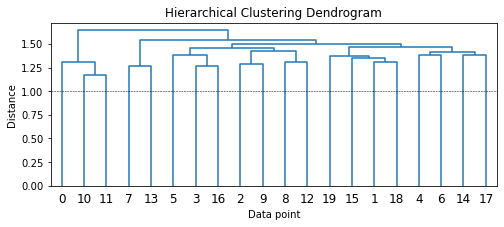

In [121]:
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

### References & Further Reading:
    
1. https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41
2. https://machinelearningmastery.com/gentle-introduction-bag-words-model/
3. https://www.geeksforgeeks.org/feature-extraction-techniques-nlp/
4. https://towardsdatascience.com/3-basic-distance-measurement-in-text-mining-5852becff1d7
5. https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089